In [2]:
import os
import pandas as pd
import numpy as np
from librosa import load as lr_load
import librosa as lr
from librosa import amplitude_to_db
from librosa.feature import melspectrogram, mfcc, chroma_stft, spectral_flatness, zero_crossing_rate, tempogram
from librosa.beat import tempo, beat_track
from librosa.feature import spectral_contrast as lf_spectral_contrast
from librosa.feature import spectral_rolloff as lf_spectral_rolloff
from librosa import pyin
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import IPython.display as ipd

In [3]:
%reset
import os
import numpy as np
import pandas as pd
import librosa as lr
from IPython.display import display
from librosa import amplitude_to_db
from librosa.feature import chroma_stft, melspectrogram, mfcc, tempogram, zero_crossing_rate
from pydub import AudioSegment
from scipy.io import wavfile
class AudioFeatureExtractor:
    def __init__(self):
        pass

    def mfccs(self, data, sfreq):
        mfcc_result = mfcc(y=data, sr=sfreq)
        datadict = {}
        for var in range(len(mfcc_result)):
            datadict[f'mfcc{var + 1}_mean'] = np.mean(mfcc_result[var, :])
        return datadict

    def calculate_spectrograms(self, audio_clips, n_fft=2048, hop_length=512, win_length=None):
        spectrograms = []
        spectrograms_db = []

        for clip in audio_clips:
            stft_matrix = lr.stft(y=clip, n_fft=n_fft, hop_length=hop_length, win_length=win_length)
            spectrogram = np.abs(stft_matrix)
            spec_db = amplitude_to_db(S=spectrogram, ref=np.max)
            spectrograms.append(spectrogram)
            spectrograms_db.append(spec_db)

        return spectrograms, spectrograms_db

    def calculate_spectral_features(self, spectrograms):
        bandwidths = []
        centroids = []

        for spectrogram in spectrograms:
            spec_bw = lr.feature.spectral_bandwidth(S=spectrogram)
            spec_cn = lr.feature.spectral_centroid(S=spectrogram)
            bandwidths.append(spec_bw)
            centroids.append(spec_cn)

        return bandwidths, centroids

    def calculate_spectral_contrast(self, data, sr, n_fft=2048, hop_length=512):
        spectral_contrast = lr.feature.spectral_contrast(y=data, sr=sr, n_fft=n_fft, hop_length=hop_length)
        return spectral_contrast

    def calculate_tonnetz(self, data, sr):
        tonnetz = lr.feature.tonnetz(y=data, sr=sr)
        return tonnetz

    def calculate_spectral_rolloff(self, data, sr, roll_percent=0.85, n_fft=2048, hop_length=512):
        spectral_rolloff = lr.feature.spectral_rolloff(y=data, sr=sr, roll_percent=roll_percent, n_fft=n_fft, hop_length=hop_length)
        return spectral_rolloff

    def calculate_chroma_features(self, data, sr, n_fft=2048, hop_length=512):
        chromagram = chroma_stft(y=data, sr=sr, n_fft=n_fft, hop_length=hop_length)
        return chromagram

    def calculate_mel_spectral_contrast(self, data, sr, n_fft=2048, hop_length=512):
        mel_spectrogram = melspectrogram(y=data, sr=sr, n_fft=n_fft, hop_length=hop_length)
        mel_spectral_contrast = lr.feature.spectral_contrast(S=mel_spectrogram)
        return mel_spectral_contrast

    def calculate_spectral_flatness(self, data, sr, n_fft=2048, hop_length=512):
        flatness = lr.feature.spectral_flatness(y=data, n_fft=n_fft, hop_length=hop_length)
        return flatness

    def zero_crossing_rate_features(self, data, n_fft=2048, hop_length=512):
        zcr = zero_crossing_rate(y=data, frame_length=n_fft, hop_length=hop_length)
        return zcr

    def calculate_tempogram(self, data, sr):
        onset_env = lr.onset.onset_strength(y=data, sr=sr)
        tempogram_result = lr.feature.tempogram(onset_envelope=onset_env, sr=sr)
        return tempogram_result

    def calculate_polyphonic_pitch(self, data, sr):
        f0, voiced_flag, voiced_probs = pyin(y=data, fmin=lr.note_to_hz('C1'), fmax=lr.note_to_hz('C8'))
        return f0, voiced_flag, voiced_probs

    def rms_energy_features(self, data):
        rms_energy = lr.feature.rms(y=data)[0]
        return rms_energy


C:\Users\latic\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [4]:
audio_extractor = AudioFeatureExtractor()

In [5]:
#Les notebook code
csv_path = "labels_new.csv"
audio_directory = "labeled"

# Read the CSV file into a DataFrame
df = pd.read_csv(csv_path)

import os
import glob
import pandas as pd
import numpy as np
import librosa as lr

def process_audio_features(df, audio_directory):
    # Audio features storage
    audio_features_list = []

    # Set the target length for audio truncation or padding
    lengte = 30 * 22050

    # Process each audio file
    for file in os.listdir(audio_directory):
        if file.endswith(".wav"):
            file_path = os.path.join(audio_directory, file)
            data, sfreq = lr.load(file_path, sr=None)

            # Truncate or pad the audio
            if len(data) > lengte:
                # Truncate the data
                data = data[:lengte]
            elif len(data) < lengte:
                # Pad with zeros
                padding = lengte - len(data)
                data = np.pad(data, (0, padding), mode='constant')

            # Extract MFCC features
            mfcc_features = audio_extractor.mfccs(data, sfreq)

            # Extract other features using the AudioFeatureExtractor class
            rms_energy = audio_extractor.rms_energy_features(data)

            # Combine all features into a dictionary
            features_dict = {
                'filename': file,  # Add the filename for identification
                'data': data,
                'sfreq': sfreq,
                **mfcc_features,
                'rms_energy': np.mean(rms_energy)
            }

            # Append the features dictionary to the list
            audio_features_list.append(features_dict)
        else:
            print(f"File {file_path} not found or not a .wav file.")

    # Convert the list of feature dictionaries to a DataFrame
    audio_features_df = pd.DataFrame(audio_features_list)

    # Merge the original DataFrame with the new features DataFrame based on the 'filename' column
    df1 = pd.merge(df, audio_features_df, on='filename', how='left')

    return df1

# Process audio features and merge with the original DataFrame
df1 = process_audio_features(df, audio_directory)

# Display the resulting DataFrame
display(df1)

,filename,genre,data,sfreq,mfcc1_mean,mfcc2_mean,mfcc3_mean,mfcc4_mean,mfcc5_mean,mfcc6_mean,...,mfcc12_mean,mfcc13_mean,mfcc14_mean,mfcc15_mean,mfcc16_mean,mfcc17_mean,mfcc18_mean,mfcc19_mean,mfcc20_mean,rms_energy
0,m00248.wav,metal,"[0.05142212, 0.07095337, 0.023956299, 0.105255...",22050,-75.517509,81.911423,-22.081079,69.876999,-11.740438,25.740246,...,14.951657,-13.525078,5.815485,-10.154532,6.781166,-10.487830,4.372530,-5.466021,2.970636,0.113753
1,m00230.wav,country,"[0.12008667, 0.17089844, 0.11740112, 0.0338439...",22050,-89.736382,36.286201,11.469535,37.495590,9.199136,3.740519,...,1.175547,-3.564297,-2.091177,1.711515,-1.367268,-4.376964,-2.601609,-3.528446,-4.227250,0.096312
2,m00637.wav,hiphop,"[0.24969482, 0.38006592, 0.30645752, 0.2945251...",22050,-122.780525,95.061287,-29.363251,46.780045,-15.998563,27.117586,...,15.645838,-6.707096,8.281756,-0.753110,9.420004,1.262813,1.674718,0.486051,1.613319,0.102282
3,m00627.wav,metal,"[0.03741455, -0.0725708, -0.11480713, -0.08319...",22050,-57.683388,101.432320,-41.485245,55.130600,-23.349279,28.151098,...,9.394469,-12.284428,4.809484,-12.406642,5.426150,-8.844725,0.059281,-3.178474,-3.361844,0.131590
4,m00138.wav,reggae,"[-0.026306152, -0.028778076, -0.0134887695, -0...",22050,-198.632797,102.413582,-10.031448,30.802383,-3.310606,20.276924,...,12.278468,-4.360509,11.402966,-3.469470,2.016131,-6.987337,1.113921,-1.494757,1.955205,0.078412
5,m00192.wav,classical,"[0.06967163, 0.06594849, 0.042388916, 0.025787...",22050,-85.264992,118.423058,-31.472771,20.282015,-4.417709,6.922597,...,-1.406447,-4.246369,-4.164333,-3.979649,0.276561,-3.392483,1.693798,-3.685389,-3.441533,0.115103
6,m00429.wav,hiphop,"[0.28259277, 0.3574829, 0.16244507, 0.125, 0.1...",22050,-109.509178,97.389565,-20.619621,37.366673,-3.125998,28.611204,...,17.939692,-3.482387,8.219098,-8.952912,9.264581,-4.989858,1.838662,-2.251433,0.675371,0.109102
7,m00623.wav,reggae,"[0.28475952, 0.24075317, 0.3190918, 0.23797607...",22050,-94.140526,68.229942,3.975480,7.631387,12.791034,-3.185735,...,-4.674421,-3.009803,-2.969258,-3.198095,-4.922947,-5.001903,1.390498,-2.088176,-2.088640,0.142932
8,m00002.wav,jazz,"[-0.016357422, -0.022827148, -0.014678955, -0....",22050,-298.807953,112.078224,6.485770,28.386517,-6.764679,16.651894,...,2.319571,-4.326794,1.407904,0.714065,13.479482,9.419415,6.914652,7.877784,-1.782740,0.050493
9,m00039.wav,reggae,"[-0.0947876, -0.15338135, -0.1439209, -0.15341...",22050,-169.243668,110.447716,-8.553957,43.898693,0.266454,26.646509,...,10.909970,-8.172387,2.804638,-6.414233,1.102364,-4.261436,4.327076,-3.458247,1.208493,0.123652


In [6]:
import os
import pandas as pd
import numpy as np
import librosa as lr

# Define the path to the audio directory
audio_directory = "unlabeled"

# Create an empty DataFrame to store the audio features
df = pd.DataFrame()

# Set the target length for audio truncation or padding
target_length = 30 * 22050

# Process each audio file
for file in os.listdir(audio_directory):
    if file.endswith(".wav"):
        file_path = os.path.join(audio_directory, file)
        data, sfreq = lr.load(file_path, sr=None)

        # Truncate or pad the audio
        if len(data) > target_length:
            # Truncate the data
            data = data[:target_length]
        elif len(data) < target_length:
            # Pad with zeros
            padding = target_length - len(data)
            data = np.pad(data, (0, padding), mode='constant')

        # Extract MFCC features
        mfcc_features = audio_extractor.mfccs(data, sfreq)

        # moet meer bij maar duurt anders te lang
        rms_energy = audio_extractor.rms_energy_features(data)

        # Combine all features into a dictionary
        features_dict = {
            'filename': file, 
            **mfcc_features,
            'rms_energy': np.mean(rms_energy)
        }

        df = pd.concat([df, pd.DataFrame([features_dict])], ignore_index=True)


df_sorted = df.sort_values(by='filename')

display(df_sorted.head())




,filename,mfcc1_mean,mfcc2_mean,mfcc3_mean,mfcc4_mean,mfcc5_mean,mfcc6_mean,mfcc7_mean,mfcc8_mean,mfcc9_mean,...,mfcc12_mean,mfcc13_mean,mfcc14_mean,mfcc15_mean,mfcc16_mean,mfcc17_mean,mfcc18_mean,mfcc19_mean,mfcc20_mean,rms_energy
0,m00003.wav,-82.501259,97.344116,-34.373585,71.405922,-3.283182,17.367373,-9.023832,16.011181,-19.003857,...,13.949616,-14.460563,7.954934,-7.123618,5.177264,-7.204545,0.667607,-4.838900,-2.107008,0.136249
1,m00012.wav,-1.925410,72.695557,-32.789642,63.592033,-18.557953,25.872955,-13.854105,18.064384,-11.945406,...,18.737663,-11.190176,7.953333,-10.283534,5.310404,-9.025781,4.315321,-5.643383,8.725261,0.217447
2,m00013.wav,-287.520996,101.737930,-35.368999,41.282764,-12.745122,17.284992,-13.978298,16.311884,-5.599029,...,-0.057106,-13.769376,6.480290,6.707885,6.985262,7.031875,8.390631,-5.610771,1.377122,0.029100
3,m00043.wav,-120.127808,91.287666,-38.794960,75.003784,-3.806012,22.666489,-8.123724,23.654572,-14.638494,...,13.706509,-9.314507,3.583581,-11.857464,1.024725,-10.713960,-3.241502,-3.466504,-4.576841,0.100442
4,m00044.wav,-437.525208,170.971405,7.386170,-3.108705,0.777301,-11.135056,-12.523805,-6.900927,-5.850052,...,-8.329373,-7.373799,-6.733424,-6.088367,-7.060068,-6.652507,-4.291024,-4.399243,-4.915998,0.018844


In [7]:

def scaler(df):
    df.set_index('filename', inplace=True)

    # Calculate mean and standard deviation
    mean_vals = df.mean(numeric_only=True)
    std_vals = df.std(ddof=0, numeric_only=True)

    # Standardize the data
    scaled_df = (df - mean_vals) / std_vals

    scaled_df['filename'] = df.index


    return scaled_df


In [8]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from IPython.display import display  

df = scaler(df_sorted)
display(df.head())


,mfcc1_mean,mfcc2_mean,mfcc3_mean,mfcc4_mean,mfcc5_mean,mfcc6_mean,mfcc7_mean,mfcc8_mean,mfcc9_mean,mfcc10_mean,...,mfcc13_mean,mfcc14_mean,mfcc15_mean,mfcc16_mean,mfcc17_mean,mfcc18_mean,mfcc19_mean,mfcc20_mean,rms_energy,filename
filename,,,,,,,,,,,,,,,,,,,,,
m00003.wav,0.484487,-0.044274,-0.953633,2.103414,-0.223317,0.781341,-0.632439,0.962736,-1.800266,0.799924,...,-1.685313,1.456281,-0.998005,0.946166,-1.056823,-0.207066,-0.931777,-0.564025,-0.005254,m00003.wav
m00012.wav,1.074915,-0.669653,-0.886789,1.719003,-1.585550,1.483047,-1.130237,1.147159,-0.935620,1.774594,...,-1.147957,1.455962,-1.687407,0.978573,-1.410926,0.791126,-1.127938,2.264119,0.947308,m00012.wav
m00013.wav,-1.017818,0.067205,-0.995640,0.621481,-1.067151,0.774544,-1.143036,0.989746,-0.158202,1.003829,...,-1.571745,1.161850,2.019628,1.386236,1.711168,1.906329,-1.119986,0.345629,-1.262254,m00013.wav
m00043.wav,0.208774,-0.197937,-1.140219,2.280413,-0.269944,1.218515,-0.539675,1.649281,-1.265517,0.965347,...,-0.839766,0.583486,-2.030792,-0.064569,-1.739159,-1.276788,-0.597140,-1.208862,-0.425318,m00043.wav
m00044.wav,-2.116991,1.823785,0.808667,-1.562392,0.138805,-1.570094,-0.993139,-1.095278,-0.188952,-1.840896,...,-0.520888,-1.476433,-0.772143,-2.032423,-0.949490,-1.563988,-0.824574,-1.297411,-1.382571,m00044.wav


In [9]:
df.drop("filename", axis=1, inplace=True)
df

,mfcc1_mean,mfcc2_mean,mfcc3_mean,mfcc4_mean,mfcc5_mean,mfcc6_mean,mfcc7_mean,mfcc8_mean,mfcc9_mean,mfcc10_mean,...,mfcc12_mean,mfcc13_mean,mfcc14_mean,mfcc15_mean,mfcc16_mean,mfcc17_mean,mfcc18_mean,mfcc19_mean,mfcc20_mean,rms_energy
filename,,,,,,,,,,,,,,,,,,,,,
m00003.wav,0.484487,-0.044274,-0.953633,2.103414,-0.223317,0.781341,-0.632439,0.962736,-1.800266,0.799924,...,1.488357,-1.685313,1.456281,-0.998005,0.946166,-1.056823,-0.207066,-0.931777,-0.564025,-0.005254
m00012.wav,1.074915,-0.669653,-0.886789,1.719003,-1.585550,1.483047,-1.130237,1.147159,-0.935620,1.774594,...,2.138239,-1.147957,1.455962,-1.687407,0.978573,-1.410926,0.791126,-1.127938,2.264119,0.947308
m00013.wav,-1.017818,0.067205,-0.995640,0.621481,-1.067151,0.774544,-1.143036,0.989746,-0.158202,1.003829,...,-0.412775,-1.571745,1.161850,2.019628,1.386236,1.711168,1.906329,-1.119986,0.345629,-1.262254
m00043.wav,0.208774,-0.197937,-1.140219,2.280413,-0.269944,1.218515,-0.539675,1.649281,-1.265517,0.965347,...,1.455360,-0.839766,0.583486,-2.030792,-0.064569,-1.739159,-1.276788,-0.597140,-1.208862,-0.425318
m00044.wav,-2.116991,1.823785,0.808667,-1.562392,0.138805,-1.570094,-0.993139,-1.095278,-0.188952,-1.840896,...,-1.535570,-0.520888,-1.476433,-0.772143,-2.032423,-0.949490,-1.563988,-0.824574,-1.297411,-1.382571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
m00971.wav,-0.715169,1.277592,-1.274369,-0.838470,-0.847983,-0.982974,-0.438186,-1.385951,-0.626994,-1.676399,...,-1.169117,0.266517,-1.033799,-0.788557,-1.524159,-0.307250,-1.304866,0.083990,0.042968,-1.147540
m00973.wav,1.026510,-1.137606,1.381634,-0.765037,0.936434,-0.155219,1.402402,0.072683,0.612714,-0.110127,...,-0.286592,0.372095,-0.688077,-0.027708,-1.121709,0.675465,-0.429937,1.430338,0.745321,1.444242
m00988.wav,0.678009,-1.588808,1.001067,-1.726364,0.406427,-0.215518,0.647399,-0.092322,1.506906,0.000735,...,0.254812,0.771619,0.368334,0.616372,-0.944779,0.066290,-0.901796,-1.066126,-1.140235,1.222169


In [11]:
data = df
data

,mfcc1_mean,mfcc2_mean,mfcc3_mean,mfcc4_mean,mfcc5_mean,mfcc6_mean,mfcc7_mean,mfcc8_mean,mfcc9_mean,mfcc10_mean,...,mfcc12_mean,mfcc13_mean,mfcc14_mean,mfcc15_mean,mfcc16_mean,mfcc17_mean,mfcc18_mean,mfcc19_mean,mfcc20_mean,rms_energy
filename,,,,,,,,,,,,,,,,,,,,,
m00003.wav,0.484487,-0.044274,-0.953633,2.103414,-0.223317,0.781341,-0.632439,0.962736,-1.800266,0.799924,...,1.488357,-1.685313,1.456281,-0.998005,0.946166,-1.056823,-0.207066,-0.931777,-0.564025,-0.005254
m00012.wav,1.074915,-0.669653,-0.886789,1.719003,-1.585550,1.483047,-1.130237,1.147159,-0.935620,1.774594,...,2.138239,-1.147957,1.455962,-1.687407,0.978573,-1.410926,0.791126,-1.127938,2.264119,0.947308
m00013.wav,-1.017818,0.067205,-0.995640,0.621481,-1.067151,0.774544,-1.143036,0.989746,-0.158202,1.003829,...,-0.412775,-1.571745,1.161850,2.019628,1.386236,1.711168,1.906329,-1.119986,0.345629,-1.262254
m00043.wav,0.208774,-0.197937,-1.140219,2.280413,-0.269944,1.218515,-0.539675,1.649281,-1.265517,0.965347,...,1.455360,-0.839766,0.583486,-2.030792,-0.064569,-1.739159,-1.276788,-0.597140,-1.208862,-0.425318
m00044.wav,-2.116991,1.823785,0.808667,-1.562392,0.138805,-1.570094,-0.993139,-1.095278,-0.188952,-1.840896,...,-1.535570,-0.520888,-1.476433,-0.772143,-2.032423,-0.949490,-1.563988,-0.824574,-1.297411,-1.382571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
m00971.wav,-0.715169,1.277592,-1.274369,-0.838470,-0.847983,-0.982974,-0.438186,-1.385951,-0.626994,-1.676399,...,-1.169117,0.266517,-1.033799,-0.788557,-1.524159,-0.307250,-1.304866,0.083990,0.042968,-1.147540
m00973.wav,1.026510,-1.137606,1.381634,-0.765037,0.936434,-0.155219,1.402402,0.072683,0.612714,-0.110127,...,-0.286592,0.372095,-0.688077,-0.027708,-1.121709,0.675465,-0.429937,1.430338,0.745321,1.444242
m00988.wav,0.678009,-1.588808,1.001067,-1.726364,0.406427,-0.215518,0.647399,-0.092322,1.506906,0.000735,...,0.254812,0.771619,0.368334,0.616372,-0.944779,0.066290,-0.901796,-1.066126,-1.140235,1.222169


In [16]:
unlabeled_data = data
unlabeled_data


,mfcc1_mean,mfcc2_mean,mfcc3_mean,mfcc4_mean,mfcc5_mean,mfcc6_mean,mfcc7_mean,mfcc8_mean,mfcc9_mean,mfcc10_mean,...,mfcc12_mean,mfcc13_mean,mfcc14_mean,mfcc15_mean,mfcc16_mean,mfcc17_mean,mfcc18_mean,mfcc19_mean,mfcc20_mean,rms_energy
filename,,,,,,,,,,,,,,,,,,,,,
m00003.wav,0.484487,-0.044274,-0.953633,2.103414,-0.223317,0.781341,-0.632439,0.962736,-1.800266,0.799924,...,1.488357,-1.685313,1.456281,-0.998005,0.946166,-1.056823,-0.207066,-0.931777,-0.564025,-0.005254
m00012.wav,1.074915,-0.669653,-0.886789,1.719003,-1.585550,1.483047,-1.130237,1.147159,-0.935620,1.774594,...,2.138239,-1.147957,1.455962,-1.687407,0.978573,-1.410926,0.791126,-1.127938,2.264119,0.947308
m00013.wav,-1.017818,0.067205,-0.995640,0.621481,-1.067151,0.774544,-1.143036,0.989746,-0.158202,1.003829,...,-0.412775,-1.571745,1.161850,2.019628,1.386236,1.711168,1.906329,-1.119986,0.345629,-1.262254
m00043.wav,0.208774,-0.197937,-1.140219,2.280413,-0.269944,1.218515,-0.539675,1.649281,-1.265517,0.965347,...,1.455360,-0.839766,0.583486,-2.030792,-0.064569,-1.739159,-1.276788,-0.597140,-1.208862,-0.425318
m00044.wav,-2.116991,1.823785,0.808667,-1.562392,0.138805,-1.570094,-0.993139,-1.095278,-0.188952,-1.840896,...,-1.535570,-0.520888,-1.476433,-0.772143,-2.032423,-0.949490,-1.563988,-0.824574,-1.297411,-1.382571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
m00971.wav,-0.715169,1.277592,-1.274369,-0.838470,-0.847983,-0.982974,-0.438186,-1.385951,-0.626994,-1.676399,...,-1.169117,0.266517,-1.033799,-0.788557,-1.524159,-0.307250,-1.304866,0.083990,0.042968,-1.147540
m00973.wav,1.026510,-1.137606,1.381634,-0.765037,0.936434,-0.155219,1.402402,0.072683,0.612714,-0.110127,...,-0.286592,0.372095,-0.688077,-0.027708,-1.121709,0.675465,-0.429937,1.430338,0.745321,1.444242
m00988.wav,0.678009,-1.588808,1.001067,-1.726364,0.406427,-0.215518,0.647399,-0.092322,1.506906,0.000735,...,0.254812,0.771619,0.368334,0.616372,-0.944779,0.066290,-0.901796,-1.066126,-1.140235,1.222169


In [17]:
labeled = df1
print(labeled)

      filename      genre                                               data  \
0   m00248.wav      metal  [0.05142212, 0.07095337, 0.023956299, 0.105255...   
1   m00230.wav    country  [0.12008667, 0.17089844, 0.11740112, 0.0338439...   
2   m00637.wav     hiphop  [0.24969482, 0.38006592, 0.30645752, 0.2945251...   
3   m00627.wav      metal  [0.03741455, -0.0725708, -0.11480713, -0.08319...   
4   m00138.wav     reggae  [-0.026306152, -0.028778076, -0.0134887695, -0...   
5   m00192.wav  classical  [0.06967163, 0.06594849, 0.042388916, 0.025787...   
6   m00429.wav     hiphop  [0.28259277, 0.3574829, 0.16244507, 0.125, 0.1...   
7   m00623.wav     reggae  [0.28475952, 0.24075317, 0.3190918, 0.23797607...   
8   m00002.wav       jazz  [-0.016357422, -0.022827148, -0.014678955, -0....   
9   m00039.wav     reggae  [-0.0947876, -0.15338135, -0.1439209, -0.15341...   
10  m00677.wav    country  [-0.17755127, -0.2388916, -0.15670776, -0.1754...   
11  m00867.wav       rock  [0.07272339, 

In [19]:
from sklearn.metrics import silhouette_score
import numpy as np

class Clustering:
    def __init__(self, data):
        self.data = data
        self.cluster_labels = None
        self.silhouette_score = None

    def calculate_silhouette_score(self):
        if self.cluster_labels is not None:
            if len(np.unique(self.cluster_labels)) > 1:
                self.silhouette_score = silhouette_score(self.data, self.cluster_labels)
            else:
                print("Silhouette score cannot be calculated with only one cluster.")
        else:
            print("Cluster labels not available. Run a clustering algorithm first.")

    def cluster_kmeans(self, n_clusters=3):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        self.cluster_labels = kmeans.fit_predict(self.data)
        self.calculate_silhouette_score()
        return np.column_stack((self.data, self.cluster_labels))

    def cluster_agglomerative(self, n_clusters=3):
        agglomerative = AgglomerativeClustering(n_clusters=n_clusters)
        self.cluster_labels = agglomerative.fit_predict(self.data)
        self.calculate_silhouette_score()
        return np.column_stack((self.data, self.cluster_labels))

    def cluster_birch(self, n_clusters=3):
        birch = Birch(n_clusters=n_clusters)
        self.cluster_labels = birch.fit_predict(self.data)
        self.calculate_silhouette_score()
        return np.column_stack((self.data, self.cluster_labels))

    def cluster_meanshift(self, bandwidth=0.5):
        meanshift = MeanShift(bandwidth=bandwidth)
        self.cluster_labels = meanshift.fit_predict(self.data)
        self.calculate_silhouette_score()
        return np.column_stack((self.data, self.cluster_labels))


clustering_instance = Clustering(data)

kmeans_result = clustering_instance.cluster_kmeans(n_clusters=3)
print("KMeans Silhouette Score:", clustering_instance.silhouette_score)

agglomerative_result = clustering_instance.cluster_agglomerative(n_clusters=3)
print("Agglomerative Silhouette Score:", clustering_instance.silhouette_score)

birch_result = clustering_instance.cluster_birch(n_clusters=3)
print("Birch Silhouette Score:", clustering_instance.silhouette_score)

meanshift_result = clustering_instance.cluster_meanshift(bandwidth=0.5)
print("MeanShift Silhouette Score:", clustering_instance.silhouette_score)


C:\Users\latic\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans Silhouette Score: 0.35015127
Agglomerative Silhouette Score: 0.33898675
Birch Silhouette Score: 0.33898675
MeanShift Silhouette Score: 0.018570961


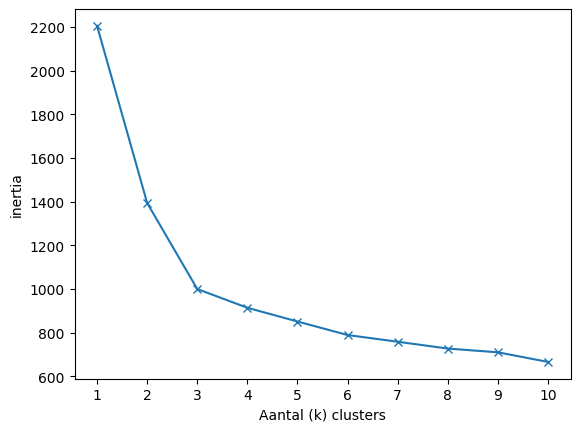

In [21]:
# overgenomen uit ml les
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, Birch, MeanShift
inertia = []
k = range(1, 11)

for i in k:
    model = KMeans(n_clusters=i, n_init=10)

    model.fit(data)

    inertia.append(model.inertia_)

plt.plot(k, inertia, '-x')
plt.xlabel('Aantal (k) clusters')
plt.ylabel('inertia')
plt.xticks(k)
plt.show()

In [22]:
from sklearn.cluster import KMeans

# Uitvoeren van K-Means om data te groeperen
k = 3  # pas het gewenste aantal clusters aan

kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)

# Clusters toevoegen aan dataframe
data['cluster'] = kmeans.fit_predict(data)

# Tonen van hoeveelheid in elk cluster
print(data['cluster'].value_counts())


cluster
2    40
0    39
1    26
Name: count, dtype: int64


In [23]:
data

,mfcc1_mean,mfcc2_mean,mfcc3_mean,mfcc4_mean,mfcc5_mean,mfcc6_mean,mfcc7_mean,mfcc8_mean,mfcc9_mean,mfcc10_mean,...,mfcc13_mean,mfcc14_mean,mfcc15_mean,mfcc16_mean,mfcc17_mean,mfcc18_mean,mfcc19_mean,mfcc20_mean,rms_energy,cluster
filename,,,,,,,,,,,,,,,,,,,,,
m00003.wav,0.484487,-0.044274,-0.953633,2.103414,-0.223317,0.781341,-0.632439,0.962736,-1.800266,0.799924,...,-1.685313,1.456281,-0.998005,0.946166,-1.056823,-0.207066,-0.931777,-0.564025,-0.005254,1
m00012.wav,1.074915,-0.669653,-0.886789,1.719003,-1.585550,1.483047,-1.130237,1.147159,-0.935620,1.774594,...,-1.147957,1.455962,-1.687407,0.978573,-1.410926,0.791126,-1.127938,2.264119,0.947308,1
m00013.wav,-1.017818,0.067205,-0.995640,0.621481,-1.067151,0.774544,-1.143036,0.989746,-0.158202,1.003829,...,-1.571745,1.161850,2.019628,1.386236,1.711168,1.906329,-1.119986,0.345629,-1.262254,2
m00043.wav,0.208774,-0.197937,-1.140219,2.280413,-0.269944,1.218515,-0.539675,1.649281,-1.265517,0.965347,...,-0.839766,0.583486,-2.030792,-0.064569,-1.739159,-1.276788,-0.597140,-1.208862,-0.425318,1
m00044.wav,-2.116991,1.823785,0.808667,-1.562392,0.138805,-1.570094,-0.993139,-1.095278,-0.188952,-1.840896,...,-0.520888,-1.476433,-0.772143,-2.032423,-0.949490,-1.563988,-0.824574,-1.297411,-1.382571,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
m00971.wav,-0.715169,1.277592,-1.274369,-0.838470,-0.847983,-0.982974,-0.438186,-1.385951,-0.626994,-1.676399,...,0.266517,-1.033799,-0.788557,-1.524159,-0.307250,-1.304866,0.083990,0.042968,-1.147540,2
m00973.wav,1.026510,-1.137606,1.381634,-0.765037,0.936434,-0.155219,1.402402,0.072683,0.612714,-0.110127,...,0.372095,-0.688077,-0.027708,-1.121709,0.675465,-0.429937,1.430338,0.745321,1.444242,0
m00988.wav,0.678009,-1.588808,1.001067,-1.726364,0.406427,-0.215518,0.647399,-0.092322,1.506906,0.000735,...,0.771619,0.368334,0.616372,-0.944779,0.066290,-0.901796,-1.066126,-1.140235,1.222169,0
